## Limited data test

Purpose of this notebook is to provide a rig to test and compare the performance of the bench mark NN, ML-ISTA and ML-JISTA network in terms of their ability to efficiently learn weight parameters to minimise empirical test error. Testing involves training the a number of these networks with varying numbers of training data points made available. Idea is perhaps that JISTA can act as a 'camel' in terms of leading fewer training data points to do a good job.

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 1
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 512
cudaopt = False

EPS = 1e-4

numb_train = [512, 1024, 4096, 10000, 20000, 60000]
train_data_sets = []

# Create different size training sets for the the training data
for i in range(len(numb_train)):
    # Mnist digits dataset
    train_data_all = torchvision.datasets.MNIST(
        root='../data',
        train=True,                                     # this is training data
        transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to                                                       # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
        download=True,                        # download it if you don't have it
    )
    
    train_data = train_data_all
    train_set = np.random.choice(60000, int(numb_train[i]))
    train_data.train_data = train_data_all.train_data[torch.LongTensor(train_set),:,:] 
    train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]
    train_data_sets.append(train_data)

# Download and load in the test data
test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

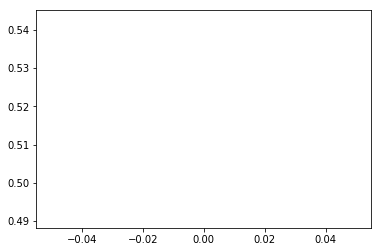

In [13]:
x = np.linspace(1,EPOCH,EPOCH)
Rhos = 1/(1+np.exp(-(x- EPOCH*6/9 )*.2))
plt.plot(Rhos)

### Test Models

In [20]:
importlib.reload(mds)

T = 0

Loss_test_baseline = np.zeros((EPOCH, len(numb_train)))
Acc_test_baseline = np.zeros((EPOCH, len(numb_train)))

Loss_test_ISTA = np.zeros((EPOCH, len(numb_train)))
Acc_test_ISTA = np.zeros((EPOCH, len(numb_train)))

Loss_test_JISTA = np.zeros((EPOCH, len(numb_train)))
Acc_test_JISTA = np.zeros((EPOCH, len(numb_train)))

print('\n\t\t\t\t\tTraining Baseline \n')

# Iterate through each of the training data set sizes
for i in range(len(numb_train)):
    print("Training and testing models with training data size of " + str(int(numb_train[i])))
    # Load data for the correct size
    train_loader = Data.DataLoader(dataset=train_data_sets[i], batch_size=BATCH_SIZE, shuffle=True)
    
    # Define the three models we want to compare     
    model_baseline = mds.ML_ISTA_NET(m1,m2,m3)
    model_ISTA = mds.ML_ISTA_NET(m1,m2,m3)
    model_JISTA = mds.ML_JISTA_NET(m1,m2,m3)
    
    # Optimise if CUDA is available   
    if cudaopt:
        model_baseline.cuda()
        model_ISTA.cuda()
        model_JISTA.cuda()
    
    # Define optimizer for each model to update a specific model's parameters    
    optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr = 0.0001, eps = EPS)
    optimizer_ISTA = torch.optim.Adam(model_ISTA.parameters(), lr = 0.0001, eps = EPS)
    optimizer_JISTA = torch.optim.Adam(model_JISTA.parameters(), lr = 0.0001, eps = EPS)
    
    bar = progressbar.ProgressBar()

    for epoch in range(EPOCH):

        bar.update((epoch+1)/EPOCH*100)
        RHO =  float(Rhos[epoch])
        # train each model for 1 epoch
        model_baseline.train()
        model_ISTA.train()
        model_JISTA.train()
        
        for step, (x, y) in enumerate(train_loader):
            b_x = Variable(x)   # batch x, shape (batch, 28*28)
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            # Run data through each model                
            encoded_baseline, scores_baseline = model_baseline(b_x)
            encoded_ISTA, scores_ISTA = model_ISTA(b_x, T, RHO)
            encoded_JISTA, scores_JISTA, sorted_labels_JISTA = model_JISTA.joint_train(b_x, b_y, T, RHO)
            # Calculate the training loss for each model and backprop
            # BASELINE            
            loss_baseline = F.nll_loss(scores_baseline, b_y)      # negative log likelyhood
            optimizer_baseline.zero_grad()               # clear gradients for this training step
            loss_baseline.backward()                     # backpropagation, compute gradients
            optimizer_baseline.step()                    # apply gradients
            # ISTA            
            loss_ISTA = F.nll_loss(scores_ISTA, b_y)      # negative log likelyhood
            optimizer_ISTA.zero_grad()               # clear gradients for this training step
            loss_ISTA.backward()                     # backpropagation, compute gradients
            optimizer_ISTA.step()                    # apply gradients
            # JISTA
            
            sorted_labels_JISTA = sorted_labels_JISTA.type(torch.LongTensor)
            scores_JISTA.type(torch.LongTensor)
#             sorted_labels_JISTA = sorted_labels_JISTA.type(torch.cuda.LongTensor)
#             scores_JISTA.type(torch.cuda.LongTensor)           
            loss_JISTA = F.nll_loss(scores_JISTA, sorted_labels_JISTA)      # negative log likelyhood
            optimizer_JISTA.zero_grad()               # clear gradients for this training step
            loss_JISTA.backward()                     # backpropagation, compute gradients
            optimizer_JISTA.step()                    # apply gradients
        
        # TEST EACH MODEL AND STORE PERFORMANCE
        model_baseline.eval()
        model_ISTA.eval()
        model_JISTA.eval()     
        correct_baseline = 0
        correct_ISTA = 0
        correct_JISTA = 0       
        test_loss_baseline = 0
        test_loss_ISTA = 0
        test_loss_JISTA = 0
        
        for step, (x, y) in enumerate(test_loader):
            b_x = Variable(x)   # batch x, shape (batch, 28*28)
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
                
            # Calculate the test loss for each model
            gamma, scores = model_baseline(b_x)
            test_loss_baseline += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_baseline += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            
            gamma, scores = model_ISTA(b_x,T,RHO)
            test_loss_ISTA += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_ISTA += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            
            gamma, scores = model_JISTA(b_x,T,RHO)
            test_loss_JISTA += F.nll_loss(scores, b_y, size_average=False).data[0]
            pred = scores.data.max(1, keepdim=True)[1]
            correct_JISTA += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
        # Calculate each error as a percentage
        test_loss_baseline /= len(test_loader.dataset)
        test_loss_ISTA /= len(test_loader.dataset)
        test_loss_JISTA /= len(test_loader.dataset)
        
        Loss_test_baseline[epoch,i] = test_loss_baseline
        Acc_test_baseline[epoch,i] =  100 * float(correct_baseline) /float(len(test_loader.dataset))
        
        Loss_test_ISTA[epoch,i] = test_loss_ISTA
        Acc_test_ISTA[epoch,i] =  100 * float(correct_ISTA) /float(len(test_loader.dataset))
        
        Loss_test_JISTA[epoch,i] = test_loss_JISTA
        Acc_test_JISTA[epoch,i] =  100 * float(correct_JISTA) /float(len(test_loader.dataset))

#     torch.save(model.state_dict(), 'cnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Baseline 

Training and testing models with training data size of 512
Running joint training
0
26
1
31
2
21
3
21
4
26
5
21
6
31
7
14
8
35
9
30
Running joint training
0
30
1
30
2
23
3
22
4
22
5
22
6
24
7
27
8
29
9
27


/Users/mmurray/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:99: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/mmurray/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:104: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/mmurray/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:109: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 1024
Running joint training
0
24
1
28
2
28
3
15
4
26
5
18
6
30
7
26
8
24
9
37
Running joint training
0
25
1
33
2
26
3
24
4
24
5
28
6
25
7
23
8
28
9
20
Running joint training
0
29
1
28
2
22
3
27
4
30
5
20
6
29
7
28
8
22
9
21
Running joint training
0
27
1
18
2
27
3
38
4
28
5
19
6
31
7
21
8
21
9
26


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 4096
Running joint training
0
17
1
42
2
23
3
26
4
22
5
19
6
25
7
32
8
32
9
18
Running joint training
0
29
1
25
2
23
3
23
4
36
5
22
6
25
7
33
8
23
9
17
Running joint training
0
31
1
25
2
29
3
29
4
29
5
28
6
20
7
29
8
22
9
14
Running joint training
0
26
1
25
2
33
3
29
4
24
5
21
6
26
7
24
8
27
9
21
Running joint training
0
20
1
31
2
24
3
27
4
18
5
25
6
25
7
30
8
26
9
30
Running joint training
0
26
1
24
2
26
3
20
4
42
5
25
6
20
7
23
8
27
9
23
Running joint training
0
29
1
30
2
25
3
20
4
35
5
19
6
29
7
23
8
28
9
18
Running joint training
0
23
1
34
2
31
3
28
4
29
5
20
6
24
7
23
8
21
9
23
Running joint training
0
27
1
28
2
30
3
22
4
19
5
12
6
28
7
28
8
28
9
34
Running joint training
0
33
1
29
2
22
3
25
4
26
5
19
6
27
7
34
8
23
9
18
Running joint training
0
27
1
35
2
26
3
25
4
24
5
32
6
19
7
19
8
22
9
27
Running joint training
0
25
1
26
2
27
3
25
4
31
5
24
6
24
7
21
8
31
9
22
Running joint training
0
29
1
26
2
27
3
31
4
29
5
15
6
32
7
21
8

/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 10000
Running joint training
0
22
1
43
2
34
3
23
4
22
5
9
6
25
7
30
8
23
9
25
Running joint training
0
23
1
25
2
28
3
34
4
31
5
28
6
15
7
29
8
20
9
23
Running joint training
0
25
1
28
2
21
3
25
4
27
5
31
6
26
7
26
8
25
9
22
Running joint training
0
21
1
30
2
20
3
29
4
35
5
25
6
22
7
22
8
26
9
26
Running joint training
0
20
1
33
2
22
3
27
4
28
5
24
6
25
7
30
8
27
9
20
Running joint training
0
18
1
28
2
17
3
28
4
33
5
30
6
25
7
32
8
20
9
25
Running joint training
0
31
1
28
2
27
3
24
4
23
5
28
6
29
7
26
8
20
9
20
Running joint training
0
24
1
25
2
34
3
24
4
27
5
17
6
18
7
34
8
29
9
24
Running joint training
0
15
1
45
2
20
3
25
4
19
5
27
6
19
7
29
8
28
9
29
Running joint training
0
22
1
31
2
23
3
22
4
27
5
23
6
27
7
33
8
26
9
22
Running joint training
0
24
1
30
2
31
3
16
4
27
5
24
6
21
7
27
8
29
9
27
Running joint training
0
21
1
30
2
17
3
25
4
34
5
23
6
20
7
32
8
31
9
23
Running joint training
0
29
1
39
2
17
3
28
4
25
5
15
6
28
7
29
8

/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 20000
Running joint training
0
32
1
26
2
23
3
22
4
31
5
25
6
26
7
19
8
25
9
27
Running joint training
0
24
1
27
2
18
3
24
4
34
5
25
6
26
7
27
8
26
9
25
Running joint training
0
19
1
31
2
26
3
28
4
24
5
19
6
26
7
31
8
17
9
35
Running joint training
0
25
1
30
2
33
3
16
4
22
5
25
6
30
7
23
8
29
9
23
Running joint training
0
24
1
35
2
26
3
22
4
26
5
29
6
22
7
28
8
14
9
30
Running joint training
0
25
1
31
2
34
3
19
4
21
5
25
6
29
7
30
8
21
9
21
Running joint training
0
25
1
41
2
21
3
31
4
19
5
21
6
34
7
26
8
21
9
17
Running joint training
0
16
1
27
2
28
3
25
4
20
5
18
6
29
7
34
8
27
9
32
Running joint training
0
28
1
28
2
23
3
21
4
27
5
27
6
20
7
24
8
27
9
31
Running joint training
0
20
1
33
2
29
3
32
4
27
5
20
6
25
7
21
8
32
9
17
Running joint training
0
25
1
26
2
26
3
29
4
29
5
18
6
28
7
30
8
27
9
18
Running joint training
0
28
1
26
2
26
3
32
4
18
5
26
6
25
7
26
8
29
9
20
Running joint training
0
16
1
32
2
22
3
22
4
22
5
31
6
24
7
34


/ |#                                                  | 0 Elapsed Time: 0:00:00

Training and testing models with training data size of 60000
Running joint training
0
29
1
31
2
22
3
24
4
27
5
22
6
20
7
26
8
31
9
24
Running joint training
0
22
1
44
2
25
3
26
4
23
5
22
6
27
7
29
8
18
9
20
Running joint training
0
30
1
37
2
26
3
27
4
21
5
16
6
26
7
28
8
23
9
22
Running joint training
0
27
1
37
2
34
3
21
4
21
5
21
6
20
7
29
8
22
9
24
Running joint training
0
28
1
29
2
22
3
23
4
19
5
27
6
26
7
31
8
27
9
24
Running joint training
0
33
1
28
2
19
3
28
4
22
5
18
6
23
7
29
8
24
9
32
Running joint training
0
25
1
22
2
20
3
29
4
20
5
36
6
20
7
29
8
30
9
25
Running joint training
0
29
1
30
2
25
3
22
4
22
5
17
6
30
7
28
8
22
9
31
Running joint training
0
19
1
27
2
21
3
23
4
32
5
25
6
32
7
25
8
29
9
23
Running joint training
0
28
1
25
2
36
3
29
4
26
5
20
6
24
7
24
8
26
9
18
Running joint training
0
26
1
37
2
27
3
22
4
23
5
22
6
15
7
31
8
26
9
27
Running joint training
0
28
1
27
2
28
3
26
4
18
5
31
6
21
7
24
8
27
9
26
Running joint training
0
30
1
23
2
23
3
29
4
23
5
19
6
24
7
37


Running joint training
0
23
1
34
2
35
3
24
4
27
5
20
6
25
7
18
8
24
9
26
Running joint training
0
24
1
34
2
22
3
32
4
19
5
28
6
28
7
27
8
20
9
22
Running joint training
0
20
1
30
2
36
3
38
4
18
5
26
6
21
7
27
8
18
9
22
Running joint training
0
22
1
29
2
27
3
21
4
33
5
20
6
27
7
27
8
25
9
25
Running joint training
0
25
1
29
2
24
3
24
4
22
5
23
6
30
7
23
8
28
9
28
Running joint training
0
26
1
27
2
26
3
31
4
28
5
22
6
25
7
26
8
22
9
23
Running joint training
0
23
1
35
2
22
3
31
4
23
5
22
6
28
7
31
8
19
9
22
Running joint training
0
29
1
24
2
31
3
27
4
22
5
27
6
21
7
26
8
22
9
27
Running joint training
0
17
1
27
2
36
3
22
4
25
5
20
6
33
7
24
8
24
9
28
Running joint training
0
20
1
22
2
28
3
29
4
21
5
38
6
19
7
27
8
25
9
27
Running joint training
0
28
1
30
2
25
3
28
4
24
5
17
6
25
7
24
8
24
9
31
Running joint training
0
28
1
17
2
28
3
31
4
19
5
20
6
33
7
26
8
22
9
32
Running joint training
0
27
1
27
2
27
3
25
4
18
5
34
6
18
7
28
8
23
9
29
Running joint training
0
23
1
42
2
25
3
33
4
14
5
2

Running joint training
0
20
1
26
2
28
3
24
4
18
5
28
6
27
7
36
8
23
9
26
Running joint training
0
31
1
25
2
26
3
31
4
16
5
25
6
22
7
32
8
29
9
19
Running joint training
0
23
1
27
2
24
3
34
4
29
5
29
6
27
7
24
8
22
9
17
Running joint training
0
30
1
29
2
23
3
26
4
21
5
26
6
27
7
27
8
23
9
24
Running joint training
0
18
1
24
2
20
3
23
4
30
5
36
6
27
7
26
8
28
9
24
Running joint training
0
22
1
32
2
27
3
27
4
24
5
24
6
31
7
21
8
28
9
20
Running joint training
0
24
1
28
2
25
3
19
4
25
5
27
6
25
7
28
8
32
9
23
Running joint training
0
28
1
27
2
29
3
17
4
30
5
22
6
32
7
20
8
29
9
22
Running joint training
0
28
1
24
2
24
3
18
4
27
5
24
6
40
7
22
8
21
9
28
Running joint training
0
8
1
16
2
11
3
4
4
8
5
11
6
10
7
7
8
10
9
11


### Plot results

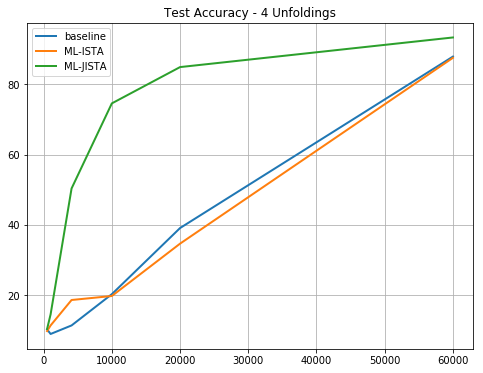

In [21]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(numb_train, Acc_test_baseline[EPOCH-1, :],  linewidth = 2,label='baseline')
plt.plot(numb_train, Acc_test_ISTA[EPOCH-1, :], linewidth = 2,label = 'ML-ISTA')
plt.plot(numb_train, Acc_test_JISTA[EPOCH-1, :], linewidth = 2,label = 'ML-JISTA')
# plt.plot(Acc_test_fista_r, linewidth = 2,label = 'ML-FISTA')

plt.grid('on')
plt.title('Test Accuracy - 4 Unfoldings')
plt.legend()
# plt.axis([0, 100, 95, 100])
plt.show()